### **Load and Test-Train Split the Data**

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **Train a Binary Classifier**

In [3]:
from sklearn.linear_model import SGDClassifier
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

### **Precision and Recall Calculation**

In [11]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

---

### Step 1: Get decision scores from SGDClassifier
Instead of just getting binary predictions (True/False), we want decision scores—which are real numbers reflecting how confidently the model predicts a positive class (5). We'll use this to test performance across different thresholds.

* `y_scores` contains the raw output of the classifier before thresholding.
* These will later be used to compute the ROC curve.

In [4]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

### Step 2: Compute FPR, TPR, and thresholds for the ROC curve
To draw the ROC curve, we calculate the True Positive Rate (TPR) and False Positive Rate (FPR) at different thresholds.

* **TPR (Recall):** out of all actual 5s, how many were correctly classified as 5.
* **FPR:** out of all non-5s, how many were wrongly predicted as 5.

In [5]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

### Step 3: Plot the ROC curve
This plot helps visualize the **trade-off between recall and false positives**. A good model hugs the top-left corner. The diagonal represents random guessing.
* The closer the curve is to the top-left, the better.
* The dashed diagonal is a baseline random classifier.

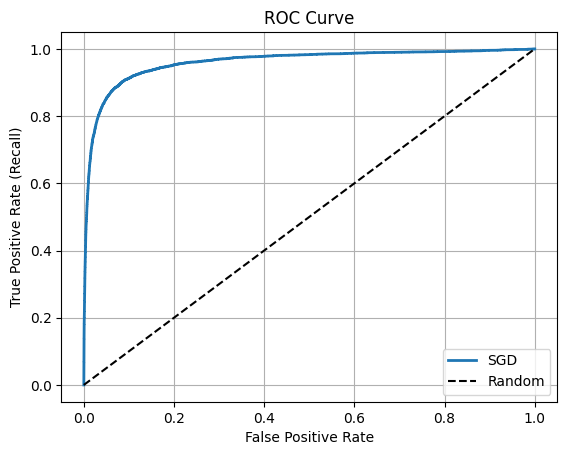

In [6]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, linewidth=2, label="SGD")
plt.plot([0, 1], [0, 1], 'k--', label="Random")  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

### Step 4: Calculate ROC AUC score
This gives a **single number** summarizing the ROC curve. The higher, the better. Perfect = 1.0, Random = 0.5.
* This evaluates how well the classifier separates the two classes across all thresholds.

In [13]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Step 5: Train a Random Forest classifier and get probabilities
Unlike SGD, `RandomForestClassifier` doesn't use a decision function. Instead, it gives class probabilities using `predict_proba()`.
* We take the probability of being class "5" from the second column (`[:, 1]`).
* These probabilities serve the same purpose as decision scores.

In [8]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)
y_scores_forest = y_probas_forest[:, 1]  # positive class probability

### Step 6: Compute PR curve and ROC AUC for RandomForest
We now use the precision-recall framework to compare Random Forest vs. SGD.
* The F1 score balances precision and recall.
* ROC AUC is again used to assess separation quality.

In [9]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score

# PR Curve
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

# ROC AUC
roc_auc_score(y_train_5, y_scores_forest)  # Expected ≈ 0.998

# F1 Score (use threshold = 0.5)
y_pred_forest = y_scores_forest >= 0.5
f1_score(y_train_5, y_pred_forest)        # Expected ≈ 0.92

0.9274509803921569

### Step 7: Compare PR Curves
Visually compare the two classifiers in terms of precision vs recall.
* `Random Forest` curve is **closer to the top-right**, indicating **better performance**.

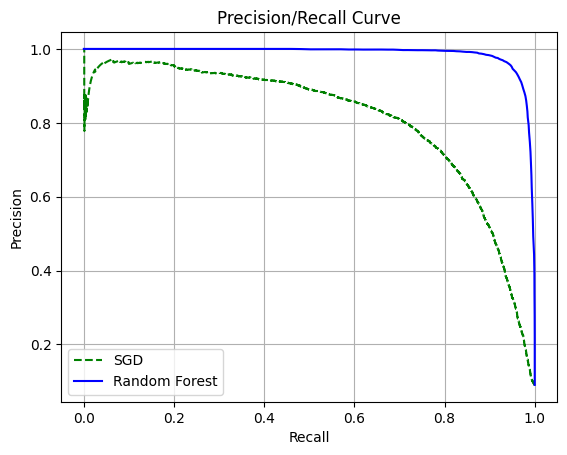

In [12]:
plt.plot(recalls, precisions, "g--", label="SGD")
plt.plot(recalls_forest, precisions_forest, "b-", label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision/Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

### **Result:**

* SGDClassifier: ROC **AUC ≈ 0.96, F1 ≈ 0.73**
* RandomForestClassifier: **ROC AUC ≈ 0.998, F1 ≈ 0.92**
* The PR curve for Random Forest is closer to the top-right corner → **better precision and recall**